## Import Libraries

In [1637]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import HeNormal, GlorotNormal, LecunNormal

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [1638]:
df = pd.read_csv('telco_data_clean.csv', index_col=False)
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,monthly_charges_cat,tenure_year
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low Expense,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,Medium Expense,3
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Medium Expense,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Medium Expense,4
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Medium High Expense,1


## Feature Engineering

In [1639]:
df["churn"]= df["churn"].map({"No": 0, "Yes": 1})

### Feature Selection

In [1640]:
# numCol = ['monthly_charges', 'tenure_year']
# catCol = ['senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
#        'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
#        'contract', 'paperless_billing', 'payment_method']
numCol = ['tenure_year', 'monthly_charges', 'total_charges']
catCol = ['senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'contract', 'paperless_billing']
# catCol = ['senior_citizen', 'online_backup', 'device_protection', 'tech_support', 'contract']
targetCol = ['churn']

In [1641]:
df = df[numCol + catCol + targetCol]

### Split X, y

In [1643]:
X = df.drop('churn', axis=1)
y = df['churn']

### Split Train, Validation, Test

In [1644]:
# Split Between Train-Set, Val-Set, and Test-Set
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size = 0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, random_state=42)

print("Train Size : ", X_train.shape)
print("Val Size : ", X_val.shape)
print("Test Size : ", X_test.shape)

Train Size :  (5080, 12)
Val Size :  (897, 12)
Test Size :  (1055, 12)


### Pipeline Scaling & Encoding

In [1645]:
num_pipeline = make_pipeline(StandardScaler())

cat_pipeline = make_pipeline(OneHotEncoder())

final_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, numCol),
    ('pipe_cat', cat_pipeline, catCol)
])

In [1646]:
# Fit and Transform
X_train_pipe = final_pipeline.fit_transform(X_train)
X_val_pipe = final_pipeline.transform(X_val)
X_test_pipe = final_pipeline.transform(X_test)

In [1647]:
# Oversampling
# smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)     # Minority Class will have same the same number as the majority class
# X_train_pipe, y_train = smote.fit_resample(X_train_pipe, y_train)
# y_train.value_counts()


# Undersampling
# undersampling = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_pipe, y_train = undersampling.fit_resample(X_train_pipe, y_train)
# y_train.value_counts()

### Data Slices

In [1648]:
train_pipe = tf.data.Dataset.from_tensor_slices((X_train_pipe,y_train)).batch(128).repeat(2).shuffle(len(y_train)).prefetch(tf.data.AUTOTUNE)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test_pipe,y_test)).batch(128)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val_pipe,y_val)).batch(128)

### Count Data Shape

In [1649]:
X_train_pipe.shape

(5080, 26)

## Model Definition (Deep Learning)

In [1650]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [1651]:
# Best Param
# Optimizer = SGD(learning_rate=0.01)
# Activation Function = Relu
# Hidden Layer = 3
# Neuron = 16, 8, 8

In [1652]:
# initializer = HeNormal(seed=seed)
initializer = GlorotNormal(seed=seed)
# initializer = LecunNormal(seed=seed)
loss_function = tf.keras.losses.BinaryCrossentropy()
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01) #nesterov=True)

model_relu = Sequential([
    Input(shape=(26,), name='input-layer'),
    Dense(16, activation='relu', kernel_initializer=initializer, name='hidden-layer-1'),
    keras.layers.BatchNormalization(),
    Dense(8, activation='relu', kernel_initializer=initializer, name='hidden-layer-2'),
    keras.layers.BatchNormalization(),
    Dense(8, activation='relu', kernel_initializer=initializer, name='hidden-layer-3'),
    keras.layers.BatchNormalization(),
    # Dense(4, activation='relu', kernel_initializer=initializer, name='hidden-layer-4'),
    # keras.layers.BatchNormalization(),
    Dense(1, activation="sigmoid", kernel_initializer=initializer, name='output-layer')
])

# Compile
model_relu.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['Precision', 'accuracy'])
model_relu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-layer-1 (Dense)      (None, 16)                432       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 hidden-layer-2 (Dense)      (None, 8)                 136       
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 hidden-layer-3 (Dense)      (None, 8)                 72        
                                                                 
 batch_normalization_2 (Bat  (None, 8)                 3

In [1653]:
# model_sequential_1 = Sequential()
# model_sequential_1.add(Dense(256, activation='relu', input_shape=(26,)))
# model_sequential_1.add(Dense(128, activation='relu'))
# model_sequential_1.add(Dense(64, activation='relu'))
# model_sequential_1.add(Dense(32, activation='relu'))
# model_sequential_1.add(Dense(1, activation='sigmoid'))


# # Compile
# model_sequential_1.compile(loss='binary_crossentropy',
#                          optimizer='adam',
#                          metrics=['Precision', 'accuracy'])

# model_sequential_1.summary()

## Model Training

In [1654]:
%%time
# Train the Model
model_relu_result = model_relu.fit(train_pipe, epochs=60, validation_data=val_pipe)

Epoch 1/60


80/80 [==============================] - 1s 5ms/step - loss: 0.6065 - precision: 0.4929 - accuracy: 0.7287 - val_loss: 0.5570 - val_precision: 0.5918 - val_accuracy: 0.7915
Epoch 2/60
80/80 [==============================] - 0s 2ms/step - loss: 0.5223 - precision: 0.5653 - accuracy: 0.7718 - val_loss: 0.4923 - val_precision: 0.6087 - val_accuracy: 0.7915
Epoch 3/60
80/80 [==============================] - 0s 3ms/step - loss: 0.4921 - precision: 0.5870 - accuracy: 0.7796 - val_loss: 0.4612 - val_precision: 0.6274 - val_accuracy: 0.8016
Epoch 4/60
80/80 [==============================] - 0s 2ms/step - loss: 0.4749 - precision: 0.6073 - accuracy: 0.7865 - val_loss: 0.4462 - val_precision: 0.6321 - val_accuracy: 0.8038
Epoch 5/60
80/80 [==============================] - 0s 2ms/step - loss: 0.4645 - precision: 0.6243 - accuracy: 0.7910 - val_loss: 0.4379 - val_precision: 0.6429 - val_accuracy: 0.8082
Epoch 6/60
80/80 [==============================] - 0s 2ms/step - loss: 0.4576 - precision:

## Model Evaluation

In [1655]:
model_relu_df = pd.DataFrame(model_relu_result.history)

<Axes: >

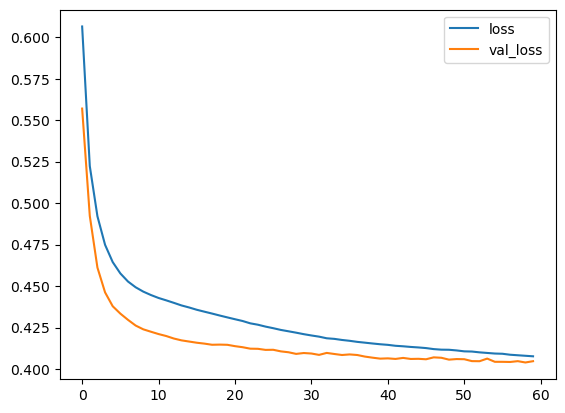

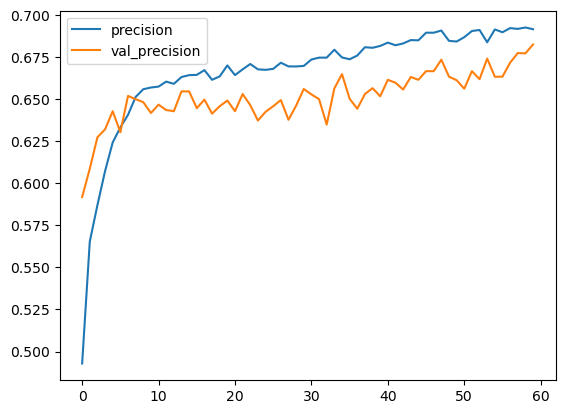

In [1656]:
model_relu_df[['loss', 'val_loss']].plot()
model_relu_df[['precision', 'val_precision']].plot()